В данном ноутбуке приведены эксперименты по обучению модели **EfficientNet B0** с использованием различных *функций потерь*, *планировщиков шага* и настройкой их *параметров*. Также проводится работа с данными, такая как применение *аугментаций*, *oversampling* и т.д.

In [1]:
# !pip install wandb

In [2]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import wandb
from collections import Counter
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, auc, precision_recall_curve
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms

In [3]:
CL = 'class'
PARAMS = 'PARAMS'
CUR_PARAMS = 'current params'

TRAIN = 'train'
VAL = 'val'
TEST = 'test'

CRITERION = 'criterion'
OPTIMIZER = 'optimizer'
SCHEDULER = 'scheduler'

TRANSFORMATIONS = 'transformations'

In [4]:
SEPARATOR = '-' * 10

In [5]:
DATA_PATH = './'

IMAGE_DIRS = {
    TRAIN: 'ISIC2018_Task3_Training_Input/',
    VAL: 'ISIC2018_Task3_Validation_Input/',
    TEST: 'ISIC2018_Task3_Test_Input/'
}

GROND_TRUTH_PATHS = {
    TRAIN: 'ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv',
    VAL: 'ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv',
    TEST: 'ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv'
}

In [6]:
RANDOM_SEED = 42

In [7]:
IMAGE_MIN_SIZE = 450  # Изображения имеют размер 450 x 600
INPUT_SIZE = 224

NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

CLASS_COUNTS = [1113, 6705, 514, 327, 1099, 115, 142]
CLASS_NAMES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
NUM_CLASSES = len(CLASS_NAMES)

NUM_EPOCHS = 20  # Для экспериментов
BATCH_SIZE = 32

LR = 1e-3

NUM_WORKERS = 2

In [8]:
WANDB_PROJECT_NAME = 'mediscan-efficient-net-b0'
WANDB_BASE_CONFIG = {
    'architecture': 'CNN-EfficientNet-B0',
    'dataset': 'ISIC2018-Task-3',
    'epochs': NUM_EPOCHS,
    'batch-size': BATCH_SIZE
}

---

In [9]:
class ISICDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir  # Путь к папке с изображениями
        self.annotations = pd.read_csv(csv_file)  # Считываем csv файл, содержащий имена изображений и их метки
        self.transform = transform  # Преобразования, которые будут применены к изображениям

    def __len__(self):
        return len(self.annotations)  # Возвращаем количество изображений в датасете, согласно csv файлу с метками

    def __getitem__(self, idx):
        # Получаем полный путь к изображению: корневая папка + имя изображения + расширение
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.jpg')

        # Открываем изображение и приводим его к RGB формату
        image = Image.open(img_path).convert('RGB')

        # Получаем метки для изображения и преобразуем их в numpy массив
        label_one_hot = self.annotations.iloc[idx, 1:].values

        # One-hot-encoded --> индекс класса
        label = np.argmax(label_one_hot)

        # Заключаем индекс класса в тензор
        label_tensor = torch.tensor(label)

        if self.transform:
            # Применяем преобразования к изображению
            image = self.transform(image)

        return image, label_tensor

---

In [62]:
# Подготовка данных
def load_data(transforms_train, transforms_eval, sampler=None):
    transform = {
        TRAIN: transforms.Compose(transforms_train),
        VAL: transforms.Compose(transforms_eval),
        TEST: transforms.Compose(transforms_eval)
    }
    
    image_datasets = {x: ISICDataset(root_dir=os.path.join(DATA_PATH, IMAGE_DIRS[x]),
                                     csv_file=os.path.join(DATA_PATH,GROND_TRUTH_PATHS[x]),
                                     transform=transform[x]) 
                      for x in [TRAIN, VAL, TEST]}
    
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS) for x in [VAL, TEST]}
    if sampler:
        dataloaders[TRAIN] = DataLoader(image_datasets[TRAIN], batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
    else:
        dataloaders[TRAIN] = DataLoader(image_datasets[TRAIN], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    return image_datasets, dataloaders

In [11]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs, labels_encoded=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch: {epoch + 1}/{num_epochs}')

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train()  # Переводим модель в режим обучения
            else:
                model.eval()  # Переводим модель в режим оценки

            print(f'Phase: {phase}')

            epoch_loss = 0.0  # Счетчик лоссов по всем объектам за эпоху
            epoch_corrects = 0  # Счетчик верных предсказаний за эпоху

            dataloader = dataloaders[phase]
            num_iterations = len(dataloader)

            # Итерация над данными
            for i, (inputs, labels) in enumerate(dataloader):
                # Хак с возвратом каретки для Google Colab
                print(f'\rIteration: {i + 1}/{num_iterations}', end='')

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Обнуляем градиенты

                # Вычисляем градиенты только если режим - TRAIN
                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                # Средний лосс по батчу
                batch_mean_loss = loss.item()

                # Кол-во объектов в текущем батче
                batch_size = inputs.size(0)

                # Суммарный лосс по всем объектам в батче
                batch_loss = batch_mean_loss * batch_size

                # Аккумулируем суммарные лоссы по батчам по мере продвижения по эпохе
                epoch_loss += batch_loss  # Эпоха завершится - здесь будет сумма лоссов по всем объектам всех батчей

                # Индексы максимальных значений - предсказания модели по объектам батча
                preds = torch.argmax(outputs, dim=1)
                
                if labels_encoded:
                    # Если метки закодированы в формате one-hot-encoded, получаем индексы классов. Это пригодится в эксперименте с BCEWithLogitsLoss
                    labels = torch.argmax(labels, dim=1)

                # Подсчитываем кол-во правильных предсказаний по текущему батчу
                batch_corrects = torch.sum(preds == labels)

                # Увеличиваем счетчик верных предсказаний за эпоху
                epoch_corrects += batch_corrects

                # Делим кол-во верных предсказаний на общее кол-во предсказаний в батче (сколько в батче объектов - столько и
                # было всего предсказаний) - получаем точность по текущему батчу.
                batch_acc = batch_corrects / batch_size

                if phase == TRAIN: # В режиме трейна логируем средний лосс и точность по текущему батчу в W&B
                    # Если последний батч в эпохе, то пока не коммитим (закоммитим вместе с логами по валидации)
                    commit = False if i == num_iterations - 1 else True
                    wandb.log({f'{phase}_batch_loss': batch_mean_loss, f'{phase}_batch_acc': batch_acc}, commit=commit)

            print('\rIterations completed')

            if phase == TRAIN:
                scheduler.step(batch_mean_loss) if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau) else scheduler.step()

            # Сколько объектов в датасете, столько и было всего сделано предсказаний за эпоху
            dataset_size = DATASET_SIZES[phase]

            # Делим сумму лоссов за эпоху по всем объектам датасета на кол-во объектов в датасете
            epoch_loss = epoch_loss / dataset_size  # Получаем средний лосс за эпоху

            # Делим кол-во верных предсказаний на общее кол-во сделанных предсказаний за эпоху - получаем точность
            epoch_acc = epoch_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end='\n\n')

            if phase == VAL:
                # Логируем лосс и точность по валидации, а также незакоммиченные логи по последнему батчу трейна
                wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_acc': epoch_acc})

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print(SEPARATOR, end='\n\n')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    
    return model, best_acc

In [12]:
def evaluate_model(model, dataloader):
    model.eval()
    total_corrects = 0

    all_labels = []
    all_preds = []
    all_probs = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        total_corrects += torch.sum(preds == labels)

    accuracy = total_corrects.double() / DATASET_SIZES[TEST]
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Считаем precision, recall, f1-score
    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES)
    print(report)

    # Считаем ROC-AUC
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print(f'ROC-AUC: {roc_auc:.4f}')
    
    # Считаем PR-AUC
    pr_auc_scores = []
    for class_ind in range(NUM_CLASSES):
        
        # Бинарные метки по текущему классу
        class_labels_binary = [1 if label == class_ind else 0 for label in all_labels]
        
        # Вероятности для текущего класса
        class_probs = [prob[class_ind] for prob in all_probs]
        
        precision, recall, _ = precision_recall_curve(class_labels_binary, class_probs)
        pr_auc_score = auc(recall, precision)
        pr_auc_scores.append(pr_auc_score)
    
    mean_pr_auc = np.mean(pr_auc_scores)
    print(f'PR-AUC: {mean_pr_auc:.4f}')

In [13]:
# Фиксируем сид
def set_random_seeds():
    np.random.seed(RANDOM_SEED)

    torch.manual_seed(RANDOM_SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_SEED)

In [14]:
def init_wandb(config):
    config = {**WANDB_BASE_CONFIG, **config}
    wandb.init(project=WANDB_PROJECT_NAME, config=config)

In [15]:
def extract_params(config, component):
    component_data = config[component]
    params = {key: value for key, value in component_data.items()if key != 'class'}
    return params

In [16]:
def get_component_class(component):
    return config[component][CL]

In [17]:
def get_component_params(config, component, value):
    if value == CUR_PARAMS:
        return extract_params(config, component)
    
    if not value:
        return {}

    return value

In [18]:
def get_criterion(criterion_class):
    if hasattr(nn, criterion_class):
        return getattr(nn, criterion_class)
    return globals()[criterion_class]


def get_optimizer(optimizer_class):
    return getattr(optim, optimizer_class)


def get_scheduler(scheduler_class):
    return getattr(lr_scheduler, scheduler_class)

In [19]:
def run_training(config_exp, dataloaders, random_seeds=True, return_model=False, train_kwargs={}):
    if random_seeds:
        set_random_seeds()

    model = copy.deepcopy(template_model).to(device)

    init_wandb(config_exp)

    criterion = get_criterion(config_exp[CRITERION][CL])(**extract_params(config_exp, CRITERION))
    optimizer = get_optimizer(config_exp[OPTIMIZER][CL])(model.parameters(), **extract_params(config_exp, OPTIMIZER))
    scheduler = get_scheduler(config_exp[SCHEDULER][CL])(optimizer, **extract_params(config_exp, SCHEDULER))

    model, acc = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, **train_kwargs)

    wandb.finish()

    return (model, acc) if return_model else acc

In [20]:
def tune_param(config_exp, component, param_name, param_values, dataloaders):    
    best_acc = 0.0
    best_param_value = None
    
    for param_value in param_values:
        print('\n' + f'{param_name}: {param_value}') 
        
        param_to_test = {param_name: param_value}

        config_exp[component] = {**config_exp[component] , **param_to_test}
                              
        acc = run_training(config_exp, dataloaders)

        if acc > best_acc:
            best_acc = acc
            best_param_value = param_value
    
    config_exp[component][param_name] = best_param_value
    
    return best_param_value, best_acc, config_exp

In [21]:
def compare_accuracy(best_current, best_experiment, config=None, config_exp=None, par_name=None, best_par_value=None, transformation=None):
    diff = abs(best_current - best_experiment)
    diff_message = f'Разница между значениями: {diff:.4f}'
    best_acc = max(best_current, best_experiment)
    
    print('\n' + f'Лучшая ранее достигнутая точность: {best_current}')
    print(f'Лучшая точность в текущем эксперименте: {best_experiment}')
    
    if best_experiment > best_current:
        verdict_message = 'Точность улучшилась'
        if par_name and best_par_value:
            verdict_message += f' при значении параметра {par_name}: {best_par_value}'
        elif transformation:
            verdict_message += f' при использовании преобразования: {transformation}'
        print(verdict_message)    
        print(diff_message)
        return best_acc, config_exp if config_exp else best_acc
    else:
        print('Точность НЕ улучшилась')
        print(diff_message)
        return (best_acc, config) if config else best_acc

In [22]:
def run_experiment(config, component, component_class, dataloaders, best_cur_acc, test_param_name=None,
                   test_param_values=None, component_params=None, train_kwargs={}):   
    component_params = get_component_params(config, component, component_params)
    
    config_exp = copy.deepcopy(config)
    config_exp[component] = {CL: component_class, **component_params}

    if test_param_name and test_param_values:
        best_test_param_value, best_exp_acc, config_exp = tune_param(config_exp, component, test_param_name, test_param_values, dataloaders)
        best_acc, config = compare_accuracy(best_cur_acc, best_exp_acc, config, config_exp, test_param_name, best_test_param_value)
        return config, best_acc, best_test_param_value
    else:
        exp_acc = run_training(config_exp, dataloaders, train_kwargs=train_kwargs)
        best_acc, config = compare_accuracy(best_cur_acc, exp_acc, config, config_exp, transformation=component_class)
        return config, best_acc

In [63]:
def run_transformations_experiment(config, data_transforms_train, data_transforms_eval, transformation_class, best_cur_acc, transformation_config=None, sampler=None):
    set_random_seeds()

    _, dataloaders = load_data(data_transforms_train, data_transforms_eval, sampler=sampler)

    config_exp = copy.deepcopy(config)
    if transformation_config:
        config_exp[TRANSFORMATIONS] = {transformation_class: transformation_config}
    else:
        config_exp[TRANSFORMATIONS] = {transformation_class: True}
        
    exp_acc = run_training(config_exp, dataloaders, random_seeds=False)

    best_acc, config = compare_accuracy(best_cur_acc, exp_acc, config, config_exp, transformation=transformation_class)

    return config, best_acc

---

In [24]:
config = {
    CRITERION: {
        CL: 'CrossEntropyLoss'
    },
    OPTIMIZER:  {
        CL: 'Adam',
        'lr': LR
    },
    SCHEDULER: {
        CL: 'StepLR',
        'step_size': 5,  # Для экспериментов
        'gamma': 1e-1,
    }
}

---

In [25]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
# Загружаем модель EfficientNet B0
weights = models.EfficientNet_B0_Weights.DEFAULT
template_model = models.efficientnet_b0(weights=weights)  

# Модифицируем классификатор в соответствии с актуальным количеством классов
num_features = template_model.classifier[1].in_features
template_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, NUM_CLASSES)  # Кол-во выходных признаков = кол-во классов
)

template_model = template_model.to(device)  # Копии этой модели будем тренировать в экспериментах

---

## Базовая модель
Сначала обучим базовую модель. Потом будем экспериментировать.

In [28]:
# Преобразования, которые будут применены к изображениям
data_transforms_train = [transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [29]:
image_datasets, dataloaders = load_data(data_transforms_train, data_transforms_eval)

In [30]:
DATASET_SIZES = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

In [31]:
base_model, best_acc = run_training(config, dataloaders, return_model=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dsaperov (dsaperov-organization). Use `wandb login --relogin` to force relogin


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6507 Acc: 0.7649

Phase: val
Iterations completed
val Loss: 0.6015 Acc: 0.7461

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.4807 Acc: 0.8255

Phase: val
Iterations completed
val Loss: 0.4250 Acc: 0.8394

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4038 Acc: 0.8522

Phase: val
Iterations completed
val Loss: 0.3995 Acc: 0.8394

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3324 Acc: 0.8777

Phase: val
Iterations completed
val Loss: 0.3588 Acc: 0.8860

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2872 Acc: 0.8917

Phase: val
Iterations completed
val Loss: 0.3856 Acc: 0.8497

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1415 Acc: 0.9519

Phase: val
Iterations completed
val Loss: 0.2888 Acc: 0.9171

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0932 Acc: 0.9677

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▂▃▅▆▇▅▃▆▆▇▇█▇█▇█▇█▇███████▇████████████
train_batch_loss,█▇▇▅▅▂▅▇▃▃▂▅▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅▇▅█▇█▇████▇▇███▇▇
val_loss,█▄▄▃▃▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃
train_batch_acc,1.0
train_batch_loss,0.00983
val_acc,0.90155
val_loss,0.36966


In [32]:
evaluate_model(base_model, dataloaders[TEST])

Accuracy: 84.46%
              precision    recall  f1-score   support

         MEL       0.73      0.61      0.67       171
          NV       0.88      0.96      0.92       909
         BCC       0.82      0.72      0.77        93
       AKIEC       0.63      0.63      0.63        43
         BKL       0.79      0.73      0.76       217
          DF       0.92      0.55      0.69        44
        VASC       0.93      0.71      0.81        35

    accuracy                           0.84      1512
   macro avg       0.81      0.70      0.75      1512
weighted avg       0.84      0.84      0.84      1512

ROC-AUC: 0.9653
PR-AUC: 0.8247


---

## Работа с дисбалансом классов
Модель демонстрирует хорошее качество предсказаний на объектах самого распространенного класса, но на других классах качество хуже. Это может быть связано с тем, что классы в датасете не сбалансированы и имеется сильный перекос в сторону одного из них.

Для того, чтобы попытаться сбалансировать классы нам понадобится рассчитать их веса.

In [33]:
class_counts = torch.tensor(CLASS_COUNTS)
min_samples_class_count = torch.min(class_counts)

In [34]:
class_weights = 1 / class_counts / min_samples_class_count
class_weights = class_weights.to(device)

### Oversampling
Согласно [одному из исследований](https://arxiv.org/abs/1710.05381), в большинстве случаев наилучшие результаты по устранению дисбаланса классов дает **oversampling**, когда мы искуственно увеличиваем число раз, когда модель встречает объекты меньших классов. Попробуем реализовать этот подход с помощью встроенного в `PyTorch` класса `WeightedRandomSampler`, но сначала посмотрим как выглядит распределение классов сейчас.

In [35]:
def visualize_dataloader(dataloader):
    all_labels = []

    for _, labels in dataloader:
        all_labels.extend(labels.numpy())

    label_counts = Counter(all_labels)

    labels, counts = zip(*label_counts.items())
    plt.bar(labels, counts)
    plt.xlabel('Class labels')
    plt.ylabel('Frequency')
    plt.title('Distribution of samples in dataloader')

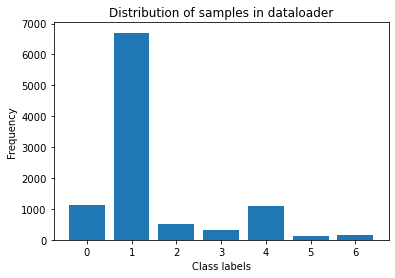

In [36]:
visualize_dataloader(dataloaders[TRAIN])

Применим **oversampling**

In [37]:
# Сохраним исходный загрузчик, чтобы потом к нему вернуться
dataloader_train_base = dataloaders[TRAIN]

In [38]:
sample_weights = np.zeros(DATASET_SIZES[TRAIN])

In [39]:
for idx, (_, label) in enumerate(image_datasets[TRAIN]):
    sample_weights[idx] = class_weights[label]
    
sample_weights = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

dataloader_train_oversampled = DataLoader(image_datasets[TRAIN], batch_size=BATCH_SIZE,
                                          sampler=sampler, num_workers=NUM_WORKERS)
dataloaders[TRAIN] = dataloader_train_oversampled

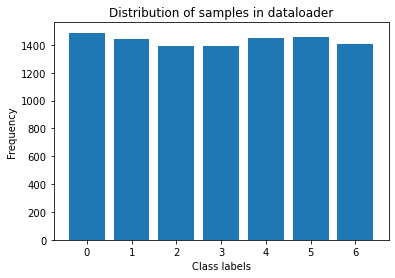

In [40]:
visualize_dataloader(dataloaders[TRAIN])

In [42]:
exp_acc = run_training(config, dataloaders)
best_acc = compare_accuracy(best_acc, exp_acc)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6491 Acc: 0.7688

Phase: val
Iterations completed
val Loss: 0.6040 Acc: 0.8031

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.3847 Acc: 0.8644

Phase: val
Iterations completed
val Loss: 0.6153 Acc: 0.7720

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.2924 Acc: 0.8961

Phase: val
Iterations completed
val Loss: 0.6703 Acc: 0.7824

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.2535 Acc: 0.9117

Phase: val
Iterations completed
val Loss: 0.4951 Acc: 0.8497

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.1889 Acc: 0.9320

Phase: val
Iterations completed
val Loss: 0.8102 Acc: 0.7772

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1222 Acc: 0.9573

Phase: val
Iterations completed
val Loss: 0.5424 Acc: 0.8549

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0855 Acc: 0.9688

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▅▄▆▅█▅▇▅▇▅█▇█▇▇▇▇▇▇███▇███▇████████████
train_batch_loss,█▃▅▄▅▂▃▂▂▂▃▁▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▃▁▂▆▁▇█▇▆██████▇▇▇▇█
val_loss,▃▄▅▁█▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂
train_batch_acc,1.0
train_batch_loss,0.00226
val_acc,0.87047
val_loss,0.54594



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.8756476683937824
Точность НЕ улучшилась
Разница между значениями: 0.0415


Стало хуже. Возможно, это связано с тем, что раньше самый большой класс, на котором модель была наиболее точна, "тащил" метрики вверх, а теперь при обучении модель гораздо реже сталкивается с объектами этого класса, и, соответственно, на валидации не распознает их также хорошо, как раньше.

Пока что уберем оверсэмплинг, чтобы опробовать другие подходы

In [44]:
dataloaders[TRAIN] = dataloader_train_base

## Подбор функции потерь
### `CrossEntropyLoss`
Альтернативный подход - считать потери с учетом дисбаланса классов.

Если применить `CrossEntropyLoss` c параметром `weight`, модель будет штрафоваться сильнее за ошибки на классах, представленных малым количеством объектов (мы как-бы говорим ей, что одинаково плохо выдавать неправильное предсказание для 7 экземпляров класса 0 и 1 неправильное предсказание для экземпляра 1). Это должно привести к улучшению перфоманса на малочисленных классах, модель должна стать более "чувствительной" к ним.

In [45]:
params = {'weight': class_weights}
config, best_acc = run_experiment(config, CRITERION, get_component_class(CRITERION), dataloaders, best_acc, component_params=params)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 1.2471 Acc: 0.5672

Phase: val
Iterations completed
val Loss: 1.6021 Acc: 0.4870

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.9754 Acc: 0.6423

Phase: val
Iterations completed
val Loss: 0.7056 Acc: 0.7358

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.7955 Acc: 0.6691

Phase: val
Iterations completed
val Loss: 0.7506 Acc: 0.6736

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.6473 Acc: 0.7184

Phase: val
Iterations completed
val Loss: 0.6876 Acc: 0.7565

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.5574 Acc: 0.7405

Phase: val
Iterations completed
val Loss: 0.7654 Acc: 0.7565

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3713 Acc: 0.7989

Phase: val
Iterations completed
val Loss: 0.4122 Acc: 0.8135

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.2883 Acc: 0.8262

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▂▅▄▃▅▃▆▅▆▇▇▅█▇▇▇▆▆▇█▆▇▇▇█▇▇▆▇█▇█▇▇▇▇▅▇
train_batch_loss,▅▄█▃▅▃▄▅▂▂▂▄▂▂▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▃▂
val_acc,▁▅▄▆▆▇▇▇▇███████████
val_loss,█▃▃▃▃▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁
train_batch_acc,0.93548
train_batch_loss,0.06571
val_acc,0.89119
val_loss,0.46039



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.8911917098445596
Точность НЕ улучшилась
Разница между значениями: 0.0259


Результат чуть лучше, чем при оверсэмплинге, но разница незначительная.

### `BCEWithLogitsLoss`
Больше подходит для multi-label классификации, но если сделать так, чтобы метки были закодированы в one-hot-encoding формате, то ее можно применить и в случае мульти-классовой классификации, хотя проблему дисбаланса классов она не решит.

In [46]:
criterion_class = 'BCEWithLogitsLoss'

In [47]:
# Модифицируем ISICDataset так, чтобы метки выдавались в one-hot-encoded формате
class ISICDatasetBCE(ISICDataset):
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label_one_hot = self.annotations.iloc[idx, 1:].values.astype(np.float32)
        label_tensor = torch.tensor(label_one_hot)

        if self.transform:
            image = self.transform(image)

        return image, label_tensor

In [48]:
transform = {
        TRAIN: transforms.Compose(data_transforms_train),
        VAL: transforms.Compose(data_transforms_eval),
        TEST: transforms.Compose(data_transforms_eval)
    }

image_datasets_bce = {x: ISICDatasetBCE(root_dir=os.path.join(DATA_PATH, IMAGE_DIRS[x]),
                                        csv_file=os.path.join(DATA_PATH,GROND_TRUTH_PATHS[x]),
                                        transform=transform[x])
                      for x in [TRAIN, VAL, TEST]}
    
dataloaders_bce = {x: DataLoader(image_datasets_bce[x], batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS) for x in [VAL, TEST]}
dataloaders_bce[TRAIN] = DataLoader(image_datasets_bce[TRAIN], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [49]:
train_kwargs = {'labels_encoded': True}
config, best_acc = run_experiment(config, CRITERION, criterion_class, dataloaders_bce, best_acc, train_kwargs=train_kwargs)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.1633 Acc: 0.7671

Phase: val
Iterations completed
val Loss: 0.1403 Acc: 0.7979

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.1199 Acc: 0.8279

Phase: val
Iterations completed
val Loss: 0.1081 Acc: 0.8497

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.1015 Acc: 0.8597

Phase: val
Iterations completed
val Loss: 0.1282 Acc: 0.8135

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.0847 Acc: 0.8822

Phase: val
Iterations completed
val Loss: 0.1278 Acc: 0.8342

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.0744 Acc: 0.8972

Phase: val
Iterations completed
val Loss: 0.0962 Acc: 0.8653

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.0382 Acc: 0.9509

Phase: val
Iterations completed
val Loss: 0.0856 Acc: 0.9016

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0262 Acc: 0.9675

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▅▃▅▅▇▇▂▆▇▇▇█▇█▇█▇█▇███████▇████████████
train_batch_loss,█▆▅▄▄▃▄▅▃▃▂▃▂▂▁▂▁▁▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▂▃▅▇▇▇█▇▇▇█▇██▇▇██
val_loss,█▄▆▆▂▁▁▃▃▄▄▄▄▄▅▅▅▅▅▅
train_batch_acc,0.96774
train_batch_loss,0.01634
val_acc,0.90674
val_loss,0.11473



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.9119170984455959
Точность НЕ улучшилась
Разница между значениями: 0.0052


### `FocalLoss`
`FocalLoss` добавляет коэффициент, увеличивая вклад ошибок на трудно классифицируемых объектах и уменьшая вклад ошибок на легко классифицируемых. Это само по себе может косвенно улучшить качество предсказаний на малочисленных классах.

In [50]:
criterion_class = 'FocalLoss'

In [51]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, labels):
        BCE_loss = F.cross_entropy(inputs, labels, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = (1 - pt) ** self.gamma * BCE_loss

        if self.alpha is not None:
            focal_loss *= self.alpha.gather(0, labels.data.view(-1))

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss  

In [52]:
config, best_acc = run_experiment(config, CRITERION, criterion_class, dataloaders, best_acc)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.3598 Acc: 0.7554

Phase: val
Iterations completed
val Loss: 0.3644 Acc: 0.6839

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.2357 Acc: 0.8126

Phase: val
Iterations completed
val Loss: 0.2359 Acc: 0.8238

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.1911 Acc: 0.8419

Phase: val
Iterations completed
val Loss: 0.2008 Acc: 0.8446

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.1491 Acc: 0.8680

Phase: val
Iterations completed
val Loss: 0.2404 Acc: 0.8342

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.1324 Acc: 0.8745

Phase: val
Iterations completed
val Loss: 0.1548 Acc: 0.8705

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.0594 Acc: 0.9371

Phase: val
Iterations completed
val Loss: 0.1199 Acc: 0.8964

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0253 Acc: 0.9681

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▂▅▅▅▆▆▄▅▇█▆▇▇█▇█▇█▇█▇▇████▇████▇████▇██
train_batch_loss,█▇▆▅▅▃▅▅▃▂▂▅▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▆▆▇██████▇▇█▇▇█▇██
val_loss,█▄▃▄▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
train_batch_acc,0.96774
train_batch_loss,0.02525
val_acc,0.89637
val_loss,0.14796



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.8963730569948187
Точность НЕ улучшилась
Разница между значениями: 0.0207


Кроме того, `FocalLoss` позволяет задать параметр `alpha`, который дает возможность учитывать дисбаланс классов. Попробуем использовать его.

In [54]:
params = {'alpha': class_weights}
config, best_acc = run_experiment(config, CRITERION, criterion_class, dataloaders, best_acc, component_params=params)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.5699

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.6321

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.6647

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.7617

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.6949

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.6373

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.7120

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.6218

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.7545

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.7617

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.8144

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.8290

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.8369

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▁▅▅▄▃▅▂▅▅▆▅▆▆█▆█▇▆▆█▇▆▆▇▇█▆▇▆▇▇▆▆▇█▆▆▆▆
train_batch_loss,█▆█▅▅▂▃▅▂▄▁▅▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂
val_acc,▁▅▁▁▅▇█▇▇███▇█▇██▇██
val_loss,█▅▇▅▄▁▁▁▁▁▂▂▂▁▁▂▁▂▂▁
train_batch_acc,0.87097
train_batch_loss,0.0
val_acc,0.84456
val_loss,0.0



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.8497409326424871
Точность НЕ улучшилась
Разница между значениями: 0.0674


Почему-то не отобразилась информация о завершающей части обучения. Лучшая точность получившейся модели - 0.8497 (данные из wandb), что меньше, чем у любой другой модели.

В итоге получилось, что лучший результат у базовой модели. 2 место - BCEWithLogitLoss. 3 - FocalLoss без использования весов.

In [56]:
# Текущая лучшая конфигурация модели исходя из значений метрики на валидации
config

{'criterion': {'class': 'CrossEntropyLoss'},
 'optimizer': {'class': 'Adam', 'lr': 0.001},
 'scheduler': {'class': 'StepLR', 'step_size': 5, 'gamma': 0.1}}

## Аугментации
Будем применять аугментации к базовой модели (так как она показала наилучшее качество на валидации), а также попробуем совместить оверсэмплинг с аугментациями, так как они по идее должны друг друга потенциировать.

In [67]:
# Для оверсэмплинга будем вести отдельный журнал
config_oversampling = copy.deepcopy(config)

# Точность базовой модели с оверсэмлингом
best_acc_oversampling = 0.8756476683937824

### `CenterCrop`

#### Без оверсэмплинга

In [57]:
transformation_class = 'CenterCrop'

In [58]:
data_transforms_train = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                         transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                        transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [59]:
config, best_acc = run_transformations_experiment(config, data_transforms_train, data_transforms_eval, transformation_class, best_acc)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6631 Acc: 0.7664

Phase: val
Iterations completed
val Loss: 0.4717 Acc: 0.8290

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.4808 Acc: 0.8222

Phase: val
Iterations completed
val Loss: 0.4260 Acc: 0.8549

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4012 Acc: 0.8548

Phase: val
Iterations completed
val Loss: 0.4375 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3320 Acc: 0.8805

Phase: val
Iterations completed
val Loss: 0.5123 Acc: 0.8135

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2836 Acc: 0.8951

Phase: val
Iterations completed
val Loss: 0.4333 Acc: 0.8446

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1399 Acc: 0.9514

Phase: val
Iterations completed
val Loss: 0.3779 Acc: 0.8964

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0930 Acc: 0.9690

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▂▄▅▅▆▃▆▇▇▆██▇██▇████▇▇██▇▇███████████▇
train_batch_loss,█▇▇▄▄▃▆▆▃▃▂▃▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▂▄▁▁▃▇▇▇█▇▇█████████
val_loss,▆▄▅█▄▂▁▃▃▅▅▄▄▄▅▅▄▅▄▄
train_batch_acc,1.0
train_batch_loss,0.00378
val_acc,0.90674
val_loss,0.43327



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.9067357512953368
Точность НЕ улучшилась
Разница между значениями: 0.0104


#### С оверсэмплингом

In [69]:
config_oversampling, best_acc_oversampling = run_transformations_experiment(config_oversampling, data_transforms_train, data_transforms_eval, transformation_class, best_acc_oversampling, sampler=sampler)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6558 Acc: 0.7612

Phase: val
Iterations completed
val Loss: 0.5900 Acc: 0.8083

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.3844 Acc: 0.8605

Phase: val
Iterations completed
val Loss: 0.6370 Acc: 0.8135

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.3199 Acc: 0.8852

Phase: val
Iterations completed
val Loss: 0.5081 Acc: 0.8238

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.1201 Acc: 0.9571

Phase: val
Iterations completed
val Loss: 0.4332 Acc: 0.8549

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.0854 Acc: 0.9707

Phase: val
Iterations completed
val Loss: 0.3764 Acc: 0.8912

----------

Epoch: 8/20
Phase: train
Iterations completed
train Loss: 0.0687 Acc: 0.9781

Phase: val
Iterations completed
val Loss: 0.3607 Acc: 0.8912

----------

Epoch: 9/20
Phase: train
Iterations completed
train Loss: 0.0617 Acc: 0.9779

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▅▃▅▅▄▅▇▇▇▇█▇██▇▇▇▇████▇███████████▇▇███
train_batch_loss,█▄█▄▅▄▄▂▃▂▃▁▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁
val_acc,▃▃▄▅▁▅▇▇▇███▇▇████▇▇
val_loss,▆▇▄▄█▃▁▁▁▂▁▂▁▁▁▂▁▂▂▁
train_batch_acc,1.0
train_batch_loss,0.00241
val_acc,0.88601
val_loss,0.37851



Лучшая ранее достигнутая точность: 0.8756476683937824
Лучшая точность в текущем эксперименте: 0.9015544041450777
Точность улучшилась при использовании преобразования: CenterCrop
Разница между значениями: 0.0259


`CenterCrop` ухудшило качество базовой модели без оверсэмплинга и улучшило качество модели с оверсэмплингом.

### `RandomVerticalFlip`
#### Без оверсэмплинга

In [70]:
transformation_class = 'RandomVerticalFlip'

In [74]:
data_transforms_train = [transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomVerticalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [75]:
config, best_acc = run_transformations_experiment(config, data_transforms_train, data_transforms_eval, transformation_class, best_acc)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6642 Acc: 0.7638

Phase: val
Iterations completed
val Loss: 0.6024 Acc: 0.7617

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.4971 Acc: 0.8189

Phase: val
Iterations completed
val Loss: 0.4305 Acc: 0.8549

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4327 Acc: 0.8402

Phase: val
Iterations completed
val Loss: 0.4631 Acc: 0.8394

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3737 Acc: 0.8624

Phase: val
Iterations completed
val Loss: 0.5594 Acc: 0.8238

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3408 Acc: 0.8749

Phase: val
Iterations completed
val Loss: 0.3695 Acc: 0.8912

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1970 Acc: 0.9293

Phase: val
Iterations completed
train Loss: 0.1163 Acc: 0.9563

Phase: val
Iterations completed
val Loss: 0.3105 Acc: 0.8860

----------

Epoch: 10/20
Phase: trai

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▃▅▄▇▆▅▅▅▇▇▆█▆████▆█▇▇█▇████▇▇▇███▇██▇▆
train_batch_loss,█▇▇▄▆▃▃▄▄▄▂▄▂▂▃▁▁▂▁▃▁▁▂▁▂▁▁▂▁▂▁▂▁▁▁▁▂▁▂▂
val_acc,▁▆▅▄▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇
val_loss,█▄▅▇▃▂▁▂▂▂▂▃▃▃▃▃▃▃▃▃
train_batch_acc,0.96774
train_batch_loss,0.04283
val_acc,0.88601
val_loss,0.36353



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.9015544041450777
Точность НЕ улучшилась
Разница между значениями: 0.0155


#### С оверсэмплингом

In [ ]:
data_transforms_train = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                         transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomVerticalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                        transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [ ]:
config_oversampling, best_acc_oversampling = run_transformations_experiment(config_oversampling, data_transforms_train, data_transforms_eval, transformation_class, best_acc_oversampling, sampler=sampler)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6817 Acc: 0.7596

Phase: val
Iterations completed
val Loss: 0.6116 Acc: 0.8031

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.4080 Acc: 0.8540

Phase: val
Iterations completed
val Loss: 0.6260 Acc: 0.7720

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.3353 Acc: 0.8808

Phase: val
Iterations completed
val Loss: 0.7739 Acc: 0.7617

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.2800 Acc: 0.8987

Phase: val
Iterations completed
val Loss: 0.5385 Acc: 0.8446

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2629 Acc: 0.9060

Phase: val
Iterations completed
val Loss: 0.7162 Acc: 0.7565

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1494 Acc: 0.9465

Phase: val
Iterations completed
val Loss: 0.4675 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.1228 Acc: 0.9541

Phase: val

Снова конец логов обрезался. Согласно данным wandb, лучшее значение метрики в данном эксперименте было 0.9016, то есть совпадает с лучшим результатом предыдущего эксперимента. Таким образом, на этот раз аугментации в обоих случаях не принесли пользы.

### `RandomRotation`
#### Без оверсэмплинга

In [85]:
transformation_class = 'RandomRotation'

In [86]:
data_transforms_train = [transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(90),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [90]:
config, best_acc = run_transformations_experiment(config, data_transforms_train, data_transforms_eval, transformation_class, best_acc)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5261 Acc: 0.8082

Phase: val
Iterations completed
val Loss: 0.4585 Acc: 0.8446

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4753 Acc: 0.8253

Phase: val
Iterations completed
val Loss: 0.4254 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4398 Acc: 0.8397

Phase: val
Iterations completed
val Loss: 0.4233 Acc: 0.8601

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3979 Acc: 0.8521

Phase: val
Iterations completed
val Loss: 0.3589 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.2901 Acc: 0.8934

Phase: val
Iterations completed
val Loss: 0.2916 Acc: 0.8860

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.2399 Acc: 0.9105

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▃▆▆▅▅▆▆▆▆▆▆▆▆▆█▄▇▆▇▆▇▆█▅█▇▇▆▇▆▇▇▇▆▇▄
train_batch_loss,█▆▇▄▅▄▅▆▄▃▃▅▃▄▂▃▂▃▁▆▂▂▂▂▂▂▁▄▂▁▂▂▁▂▂▁▂▃▂▄
val_acc,▁▄▂▅▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇█
val_loss,█▆▅▅▃▂▂▂▁▂▁▁▁▁▇▂▁▂▁▁
train_batch_acc,0.96774
train_batch_loss,0.18901
val_acc,0.92228
val_loss,0.25997



Лучшая ранее достигнутая точность: 0.917098445595855
Лучшая точность в текущем эксперименте: 0.922279792746114
Точность улучшилась при использовании преобразования: RandomRotation
Разница между значениями: 0.0052


#### С оверсэмплингом

In [93]:
data_transforms_train = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                         transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(90),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                        transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [94]:
config_oversampling, best_acc_oversampling = run_transformations_experiment(config_oversampling, data_transforms_train, data_transforms_eval, transformation_class, best_acc_oversampling, sampler=sampler)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7504 Acc: 0.7299

Phase: val
Iterations completed
val Loss: 0.6387 Acc: 0.7720

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.4962 Acc: 0.8250

Phase: val
Iterations completed
val Loss: 0.7046 Acc: 0.7461

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4218 Acc: 0.8468

Phase: val
Iterations completed
val Loss: 0.5880 Acc: 0.7876

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3657 Acc: 0.8662

Phase: val
Iterations completed
val Loss: 0.6870 Acc: 0.7979

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3060 Acc: 0.8897

Phase: val
Iterations completed
val Loss: 0.6731 Acc: 0.7565

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.2119 Acc: 0.9221

Phase: val
Iterations completed
val Loss: 0.4680 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.1732 Acc: 0.9362

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▅▅▅▆▄▇▅▆▇█▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇█▇█▇▇▇▇▇▇
train_batch_loss,█▅▄▄▅▂▄▃▃▂▂▁▃▁▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▂▁▁▁▂▂▂▁▁▂
val_acc,▂▁▃▃▁▅▇▆▇▇▇▇█▇█▇████
val_loss,▇█▆█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.96774
train_batch_loss,0.06798
val_acc,0.88601
val_loss,0.3691



Лучшая ранее достигнутая точность: 0.9015544041450777
Лучшая точность в текущем эксперименте: 0.8963730569948187
Точность НЕ улучшилась
Разница между значениями: 0.0052


### `ColorJitter`
#### Без оверсэмплинга

In [95]:
transformation_class = 'ColorJitter'

In [97]:
color_jitter_configs = [{'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.2},
                        {'brightness': 0.3, 'contrast': 0.3, 'saturation': 0.3, 'hue': 0.1}]

In [100]:
for cj_config in color_jitter_configs:
    data_transforms_train = [transforms.Resize(INPUT_SIZE),
                             transforms.RandomHorizontalFlip(),
                             transforms.RandomRotation(90),
                             transforms.ColorJitter(**cj_config),
                             transforms.ToTensor(),
                             transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

    data_transforms_eval = [transforms.Resize(INPUT_SIZE),
                            transforms.ToTensor(),
                            transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]
    
    config, best_acc = run_transformations_experiment(config, data_transforms_train, data_transforms_eval,
                                                      transformation_class, best_acc, cj_config)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7661 Acc: 0.7304

Phase: val
Iterations completed
val Loss: 0.7063 Acc: 0.7461

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.6173 Acc: 0.7788

Phase: val
Iterations completed
val Loss: 0.5610 Acc: 0.8187

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.5648 Acc: 0.7927

Phase: val
Iterations completed
val Loss: 0.5091 Acc: 0.7720

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.5247 Acc: 0.8100

Phase: val
Iterations completed
val Loss: 0.4867 Acc: 0.8394

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.4993 Acc: 0.8137

Phase: val
Iterations completed
val Loss: 0.4746 Acc: 0.8135

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3991 Acc: 0.8523

Phase: val
Iterations completed
val Loss: 0.3880 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3381 Acc: 0.8738

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▃▃▄▇▃▃▅▅▆▃▆▆▅▆█▆▇▃▇▃▆▇▄▇▆▄█▇▆▇▆▆▄▅█▅▃▃
train_batch_loss,██▆▅▇▂▅▄▅▃▃▇▂▃▄▃▁▃▃▄▁▃▂▂▄▂▁▄▂▁▃▁▂▃▄▃▁▃▅▄
val_acc,▁▅▃▆▅▆▇▇▇▇▇▇███▇▇██▇
val_loss,█▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.83871
train_batch_loss,0.46175
val_acc,0.85492
val_loss,0.34997



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.8652849740932643
Точность НЕ улучшилась
Разница между значениями: 0.0570


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7559 Acc: 0.7270

Phase: val
Iterations completed
val Loss: 0.7008 Acc: 0.7098

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.6148 Acc: 0.7767

Phase: val
Iterations completed
val Loss: 0.4790 Acc: 0.8342

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.5598 Acc: 0.7971

Phase: val
Iterations completed
val Loss: 0.5732 Acc: 0.7565

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.5156 Acc: 0.8150

Phase: val
Iterations completed
val Loss: 0.5141 Acc: 0.7979

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3350 Acc: 0.8750

Phase: val
Iterations completed
val Loss: 0.3205 Acc: 0.8860

----------

Epoch: 8/20
Phase: train
Iterations completed
train Loss: 0.3249 Acc: 0.8778

Phase: val
Iterations completed
val Loss: 0.3358 Acc: 0.8808

----------

Epoch: 9/20
Phase: train
Iterations completed
train Loss: 0.3045 Acc: 0.8840

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▂▃▄▅▇▄▄▅▆▇▄▆▅▅▅▇▆▇▄▅▅▅▇▃▇█▄▆▇▅▇▆▆▅▅▇▃▅▅
train_batch_loss,██▇▅▆▃▅▅▄▃▃▆▂▃▅▄▁▃▂▃▂▃▂▁▅▂▁▄▂▂▃▂▂▂▄▃▂▅▄▅
val_acc,▁▅▃▄▃▆▇▇▇▇▇▇███████▇
val_loss,█▄▆▅▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.87097
train_batch_loss,0.37206
val_acc,0.90155
val_loss,0.27521



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.917098445595855
Точность НЕ улучшилась
Разница между значениями: 0.0052


#### С оверсэмплингом

In [103]:
for cj_config in color_jitter_configs:
    data_transforms_train = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                             transforms.Resize(INPUT_SIZE),
                             transforms.RandomHorizontalFlip(),
                             transforms.ColorJitter(**cj_config),
                             transforms.ToTensor(),
                             transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

    data_transforms_eval = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                            transforms.Resize(INPUT_SIZE),
                            transforms.ToTensor(),
                            transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]
    
    config_oversampling, best_acc_oversampling = run_transformations_experiment(config_oversampling,
                                                                                data_transforms_train, 
                                                                                data_transforms_eval,
                                                                                transformation_class,
                                                                                best_acc_oversampling, 
                                                                                cj_config, sampler=sampler)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.8185 Acc: 0.7052

Phase: val
Iterations completed
val Loss: 0.6593 Acc: 0.7772

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5188 Acc: 0.8094

Phase: val
Iterations completed
val Loss: 0.8322 Acc: 0.7461

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.3994 Acc: 0.8539

Phase: val
Iterations completed
val Loss: 0.6132 Acc: 0.8135

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3541 Acc: 0.8721

Phase: val
Iterations completed
val Loss: 0.7531 Acc: 0.7979

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2882 Acc: 0.8939

Phase: val
Iterations completed
val Loss: 0.8622 Acc: 0.7565

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1952 Acc: 0.9309

Phase: val
Iterations completed
val Loss: 0.6536 Acc: 0.8187

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.1480 Acc: 0.9449

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▄▆▅▅▄▅▆▇▆▇▆▇▅▆▇▇▆████▇███▆██▇█▇█▇▇▇▇▇▇
train_batch_loss,█▅▅▃▄▄▄▃▃▂▃▂▂▂▃▃▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▂
val_acc,▃▁▆▅▂▆▇██▇▆▇▇▇█▇▇▇▇▇
val_loss,▂▇▁▅█▂▁▁▃▂▂▂▂▂▂▂▂▂▂▂
train_batch_acc,0.96774
train_batch_loss,0.03804
val_acc,0.82383
val_loss,0.63974



Лучшая ранее достигнутая точность: 0.9015544041450777
Лучшая точность в текущем эксперименте: 0.844559585492228
Точность НЕ улучшилась
Разница между значениями: 0.0570


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7992 Acc: 0.7091

Phase: val
Iterations completed
val Loss: 0.6274 Acc: 0.7772

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5013 Acc: 0.8176

Phase: val
Iterations completed
val Loss: 0.6948 Acc: 0.7668

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.3991 Acc: 0.8535

Phase: val
Iterations completed
val Loss: 0.5693 Acc: 0.8135

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3496 Acc: 0.8758

Phase: val
Iterations completed
val Loss: 0.6514 Acc: 0.7979

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2867 Acc: 0.8958

Phase: val
Iterations completed
val Loss: 0.8252 Acc: 0.7254

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1871 Acc: 0.9308

Phase: val
Iterations completed
val Loss: 0.5271 Acc: 0.8446

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.1421 Acc: 0.9488

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▆▅▅▆▆▆▆▆█▆▇▇▇▇▇▇█▇██████▇█▇██▇█████████
train_batch_loss,█▄▄▄▅▄▄▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_acc,▄▃▅▅▁▇▇▆▇▆▇███████▇█
val_loss,▄▅▃▄█▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁
train_batch_acc,0.96774
train_batch_loss,0.04601
val_acc,0.8601
val_loss,0.49489



Лучшая ранее достигнутая точность: 0.9015544041450777
Лучшая точность в текущем эксперименте: 0.8704663212435233
Точность НЕ улучшилась
Разница между значениями: 0.0311


### `RandomPerspective`
#### Без оверсэмплинга

In [104]:
transformation_class = 'RandomPerspective'

In [107]:
data_transforms_train = [transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(90),
                         transforms.RandomPerspective(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [108]:
config, best_acc = run_transformations_experiment(config, data_transforms_train, data_transforms_eval, transformation_class, best_acc)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7142 Acc: 0.7491

Phase: val
Iterations completed
val Loss: 0.6095 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5670 Acc: 0.7937

Phase: val
Iterations completed
val Loss: 0.5660 Acc: 0.8083

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.5099 Acc: 0.8135

Phase: val
Iterations completed
val Loss: 0.4006 Acc: 0.8705

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4706 Acc: 0.8273

Phase: val
Iterations completed
val Loss: 0.4410 Acc: 0.8342

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.4427 Acc: 0.8355

Phase: val
Iterations completed
val Loss: 0.4062 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3419 Acc: 0.8720

Phase: val
Iterations completed
val Loss: 0.2931 Acc: 0.9016

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.2970 Acc: 0.8868

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▃▃▃▃▃▃▄▆▆▂▆▆▄▃▆▆▅▃█▆▆▆▆▇█▃▆▆▆▇▆▃▆▆▆▆▆▅
train_batch_loss,█▇▆▆▇▄▇▆▅▄▃▇▂▄▃▄▂▃▃▅▁▃▃▃▄▂▁▅▂▂▃▂▂▄▃▂▂▃▃▃
val_acc,▁▂▆▃▅▇▇▇█▇▇█▇▇▇█▇▇█▇
val_loss,█▇▄▅▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.93548
train_batch_loss,0.12776
val_acc,0.90155
val_loss,0.28097



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.9119170984455959
Точность НЕ улучшилась
Разница между значениями: 0.0104


#### С оверсэмплингом

In [110]:
data_transforms_train = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                         transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomPerspective(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                        transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [111]:
config_oversampling, best_acc_oversampling = run_transformations_experiment(config_oversampling, data_transforms_train, data_transforms_eval, transformation_class, best_acc_oversampling, sampler=sampler)

Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7469 Acc: 0.7324

Phase: val
Iterations completed
val Loss: 0.6242 Acc: 0.7772

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.4818 Acc: 0.8255

Phase: val
Iterations completed
val Loss: 0.6601 Acc: 0.7720

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.3777 Acc: 0.8612

Phase: val
Iterations completed
val Loss: 0.5540 Acc: 0.8394

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3462 Acc: 0.8731

Phase: val
Iterations completed
val Loss: 0.6692 Acc: 0.8031

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2862 Acc: 0.8955

Phase: val
Iterations completed
val Loss: 0.6150 Acc: 0.7876

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.1991 Acc: 0.9278

Phase: val
Iterations completed
val Loss: 0.4557 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.1544 Acc: 0.9446

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▇▅▅▅▇▅▇▅▇▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇███▇▇▇▇█▇
train_batch_loss,█▅▄▃▅▄▃▃▄▃▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁▂▂▁▁▂
val_acc,▁▁▅▃▂▅▇▇█████▇▇▇▇▇▇▇
val_loss,▇█▅█▇▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁
train_batch_acc,1.0
train_batch_loss,0.01719
val_acc,0.88601
val_loss,0.3857



Лучшая ранее достигнутая точность: 0.9015544041450777
Лучшая точность в текущем эксперименте: 0.8963730569948187
Точность НЕ улучшилась
Разница между значениями: 0.0052


---

### Резюме
Какие бы аугментации мы не применяли, модель без оверсэмплинга на валидационной выборке всегда обгоняла модель с оверсэмплингом. Также нельзя сказать, что аугментации сами по себе значительно улучшали перфоманс модели в обоих случаях. И там и там было отобрано по одному типу преобразования, которому удалось повысить значение метрики на валидационной выборке. Остальные аугментации либо ухудшали качество, либо давали результат, который был достижим и без них.

Таким образом, теперь осталось подобрать параметры оптимайзера и щедулера. На данном этапе придется отказаться от модели с оверсэмплингом в пользу базовой модели с примененной аугментацией `RandomRotation(90)`.

Создадим загрузчик, который и будем дальше использовать.

In [112]:
config[TRANSFORMATIONS]

{'RandomRotation': True}

In [113]:
data_transforms_train = [transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(90),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [114]:
image_datasets, dataloaders = load_data(data_transforms_train, data_transforms_eval)

---

## Подбор параметров оптимайзера
### `weight_decay`

In [115]:
WEIGHT_DECAYS = [1e-4, 1e-3, 1e-2]

In [116]:
param_name = 'weight_decay'
config, best_acc, _ = run_experiment(config, OPTIMIZER, get_component_class(OPTIMIZER), dataloaders,
                                     best_acc, param_name, WEIGHT_DECAYS, component_params=CUR_PARAMS)


weight_decay: 0.0001


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6766 Acc: 0.7579

Phase: val
Iterations completed
val Loss: 0.6015 Acc: 0.7617

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5360 Acc: 0.8047

Phase: val
Iterations completed
val Loss: 0.4375 Acc: 0.8653

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4815 Acc: 0.8233

Phase: val
Iterations completed
val Loss: 0.4511 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4485 Acc: 0.8334

Phase: val
Iterations completed
val Loss: 0.3583 Acc: 0.8808

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.4160 Acc: 0.8498

Phase: val
Iterations completed
val Loss: 0.3905 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3062 Acc: 0.8903

Phase: val
Iterations completed
val Loss: 0.2768 Acc: 0.8860

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.2553 Acc: 0.9056

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▅▂▃▃▅▃▃▅▅▆▃▆▅▅▆▇▇▆▆█▇▄▆▇▇█▅▆▆▇▇█▆▇▆█▆▆▆
train_batch_loss,█▇█▆▆▃▆▆▄▄▃▆▃▄▃▂▂▂▂▄▁▃▃▂▂▂▁▃▂▂▂▂▁▂▂▂▁▂▃▃
val_acc,▁▆▄▇▅▇▇▇▇███████████
val_loss,█▅▅▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.93548
train_batch_loss,0.16629
val_acc,0.91192
val_loss,0.27499



weight_decay: 0.001


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6979 Acc: 0.7520

Phase: val
Iterations completed
val Loss: 0.5548 Acc: 0.8135

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5933 Acc: 0.7867

Phase: val
Iterations completed
val Loss: 0.5421 Acc: 0.7772

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.5734 Acc: 0.7936

Phase: val
Iterations completed
val Loss: 0.5450 Acc: 0.7668

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.5679 Acc: 0.7935

Phase: val
Iterations completed
val Loss: 0.6671 Acc: 0.7720

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.5538 Acc: 0.7982

Phase: val
Iterations completed
val Loss: 0.4944 Acc: 0.8601

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.4413 Acc: 0.8396

Phase: val
Iterations completed
val Loss: 0.3845 Acc: 0.8705

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3862 Acc: 0.8584

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▂▃▃▄▃▄▃▃▃▆▆▂▅▄▅▅▃▅▄▃▇▆▅▆▅▆█▁▄▆▆▄▅▆▆▅▆▅▆▂
train_batch_loss,█▇▇▅▇▄▇▆▆▄▃▇▄▄▆▅▄▃▄▆▃▃▃▃▃▃▁▇▄▃▃▃▃▃▄▃▂▄▃▅
val_acc,▃▂▁▁▆▆▇▇▇▇▇▇▇▇████▇█
val_loss,▆▆▆█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.93548
train_batch_loss,0.22842
val_acc,0.90155
val_loss,0.3273



weight_decay: 0.01


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.7953 Acc: 0.7183

Phase: val
Iterations completed
val Loss: 1.0502 Acc: 0.6528

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.7659 Acc: 0.7237

Phase: val
Iterations completed
val Loss: 0.9801 Acc: 0.6373

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.7956 Acc: 0.7111

Phase: val
Iterations completed
val Loss: 0.8147 Acc: 0.7098

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.7719 Acc: 0.7178

Phase: val
Iterations completed
val Loss: 0.8991 Acc: 0.6528

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.7668 Acc: 0.7159

Phase: val
Iterations completed
val Loss: 0.7807 Acc: 0.7202

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.6864 Acc: 0.7496

Phase: val
Iterations completed
val Loss: 0.6394 Acc: 0.7720

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.6543 Acc: 0.7598

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▆▅▅▃▃▅▆▃▇█▂▅▇▂▅█▆▃▅▇▅▇▃▇▇█▂▇█▅▅▇▅▁▇▆▆▆▃
train_batch_loss,▆▄▅▄▇▅▅▃▄▄▂▆▄▃█▆▄▃▄▆▃▃▃▃▃▅▁█▄▂▆▄▃▃█▂▃▃▃▆
val_acc,▂▁▃▂▄▅▇▆▅▅█▇▇██████▇
val_loss,█▇▅▆▅▃▂▂▃▂▁▁▁▁▁▁▁▁▁▁
train_batch_acc,0.83871
train_batch_loss,0.47504
val_acc,0.8342
val_loss,0.4993



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.9119170984455959
Точность НЕ улучшилась
Разница между значениями: 0.0104


---

## Выбор планировщика шага
### `ReduceLROnPlateau`

In [118]:
sheduler_class = 'ReduceLROnPlateau'

#### Параметр `patience`

In [119]:
PATIENCES = [3, 6]

In [120]:
param_name = 'patience'
config, best_acc, best_patience = run_experiment(config, SCHEDULER, sheduler_class, dataloaders, best_acc, param_name, PATIENCES)


patience: 3


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5261 Acc: 0.8082

Phase: val
Iterations completed
val Loss: 0.4585 Acc: 0.8446

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4753 Acc: 0.8253

Phase: val
Iterations completed
val Loss: 0.4254 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4398 Acc: 0.8397

Phase: val
Iterations completed
val Loss: 0.4233 Acc: 0.8601

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3979 Acc: 0.8521

Phase: val
Iterations completed
val Loss: 0.3589 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3751 Acc: 0.8609

Phase: val
Iterations completed
val Loss: 0.4543 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3502 Acc: 0.8694

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▃▆▆▅▅▆▄▃▆▆▆▆▅▆▆▆▆▅▆▆▆▇█▆▇█▇▆▇▆▆▇█▇▆▆
train_batch_loss,█▆▇▄▅▄▆▆▄▄▃▆▄▃▃▃▃▂▃▄▃▄▂▃▂▂▁▃▂▁▂▂▂▂▂▁▁▁▂▂
val_acc,▁▄▃▅▅▄▇▃▇▇▇█▇▇█▇▇▇▆█
val_loss,█▅▄▄▂▅▂▆▄▃▁▂▂▁▂▃▃▁▃▃
train_batch_acc,1.0
train_batch_loss,0.01594
val_acc,0.90155
val_loss,0.37049



patience: 6


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5261 Acc: 0.8082

Phase: val
Iterations completed
val Loss: 0.4585 Acc: 0.8446

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4753 Acc: 0.8253

Phase: val
Iterations completed
val Loss: 0.4254 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4398 Acc: 0.8397

Phase: val
Iterations completed
val Loss: 0.4233 Acc: 0.8601

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3979 Acc: 0.8521

Phase: val
Iterations completed
val Loss: 0.3589 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3751 Acc: 0.8609

Phase: val
Iterations completed
val Loss: 0.4543 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3502 Acc: 0.8694

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▃▆▆▅▅▆▄▃▆▆▆▆▅▆▆▆▆▅▆▆▆▆▆▃▅█▇▇█▆▇█▆██▇
train_batch_loss,█▆▇▄▅▄▅▆▄▄▃▆▄▃▃▃▃▂▃▄▃▄▂▃▃▂▂▅▄▁▂▂▁▂▁▁▂▁▁▂
val_acc,▁▄▃▅▅▄▇▃▇▇▇▆▇▆▇█▇▆▇█
val_loss,█▅▄▄▂▅▂▆▄▂▁▄▂▅▁▁▂▃▃▃
train_batch_acc,1.0
train_batch_loss,0.01097
val_acc,0.90674
val_loss,0.39152



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.9067357512953368
Точность НЕ улучшилась
Разница между значениями: 0.0155


In [122]:
params = {param_name: best_patience}

#### Параметр `factor`

In [124]:
FACTORS = [0.3, 0.5]

In [125]:
param_name = 'factor'
config, best_acc, _ = run_experiment(config, SCHEDULER, sheduler_class, dataloaders, best_acc, param_name, FACTORS, component_params=params)


factor: 0.3


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5261 Acc: 0.8082

Phase: val
Iterations completed
val Loss: 0.4585 Acc: 0.8446

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4753 Acc: 0.8253

Phase: val
Iterations completed
val Loss: 0.4254 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4398 Acc: 0.8397

Phase: val
Iterations completed
val Loss: 0.4233 Acc: 0.8601

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3979 Acc: 0.8521

Phase: val
Iterations completed
val Loss: 0.3589 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3751 Acc: 0.8609

Phase: val
Iterations completed
val Loss: 0.4543 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3502 Acc: 0.8694

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▃▆▆▅▅▆▄▃▆▆▆▆▅▆▆▆▆▅▆▆▆▆█▆▇█▆▇▇▇▇███▇▆
train_batch_loss,█▆▇▄▅▄▆▆▄▄▃▆▄▃▃▃▃▂▃▄▃▄▂▃▂▂▁▃▂▁▂▂▁▂▂▁▁▁▁▂
val_acc,▁▅▃▆▅▄▇▃████▆█████▇█
val_loss,█▅▄▄▂▅▂▆▄▂▁▂▄▁▂▃▂▂▃▄
train_batch_acc,1.0
train_batch_loss,0.01819
val_acc,0.89637
val_loss,0.42862



factor: 0.5


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5261 Acc: 0.8082

Phase: val
Iterations completed
val Loss: 0.4585 Acc: 0.8446

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4753 Acc: 0.8253

Phase: val
Iterations completed
val Loss: 0.4254 Acc: 0.8187

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4398 Acc: 0.8397

Phase: val
Iterations completed
val Loss: 0.4233 Acc: 0.8601

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3979 Acc: 0.8521

Phase: val
Iterations completed
val Loss: 0.3589 Acc: 0.8549

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3751 Acc: 0.8609

Phase: val
Iterations completed
val Loss: 0.4543 Acc: 0.8394

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3502 Acc: 0.8694

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▃▆▆▅▅▆▄▃▆▆▆▆▅▆▆▆▆▅▇▆▆▆█▆█▆▇▆█▆▇█▇██▆
train_batch_loss,█▇▇▄▅▄▆▆▄▄▃▆▄▄▃▃▃▂▃▄▃▄▂▃▂▂▁▄▂▂▂▃▁▂▂▁▂▁▁▂
val_acc,▁▄▂▅▅▄▆▃▇▇▇▆▆▆▆▆▆▇█▇
val_loss,█▅▄▄▂▅▂▆▄▂▁▁▅▂▂▃▃▂▁▆
train_batch_acc,1.0
train_batch_loss,0.00812
val_acc,0.89637
val_loss,0.48882



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.917098445595855
Точность НЕ улучшилась
Разница между значениями: 0.0052


### `CyclicLR`

In [127]:
sheduler_class = 'CyclicLR'

#### Параметр `step_size_up`

In [128]:
STEP_SIZE_UP = [NUM_EPOCHS // 2, NUM_EPOCHS // 4]

In [129]:
param_name = 'step_size_up'
base_lr = 1e-5
max_lr = 1e-3
mode = 'triangular2'

In [130]:
params = {'base_lr': base_lr, 'max_lr': max_lr, 'mode': mode, 'cycle_momentum': False}

In [131]:
param_name = 'step_size_up'
config, best_acc, _ = run_experiment(config, SCHEDULER, sheduler_class, dataloaders, best_acc, param_name, STEP_SIZE_UP, component_params=params)


step_size_up: 10


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 1.4659 Acc: 0.5981

Phase: val
Iterations completed
val Loss: 1.2082 Acc: 0.6788

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.6517 Acc: 0.7767

Phase: val
Iterations completed
val Loss: 0.4599 Acc: 0.8653

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4889 Acc: 0.8231

Phase: val
Iterations completed
val Loss: 0.3957 Acc: 0.8653

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4297 Acc: 0.8459

Phase: val
Iterations completed
val Loss: 0.3774 Acc: 0.8756

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3916 Acc: 0.8557

Phase: val
Iterations completed
val Loss: 0.3104 Acc: 0.8964

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.3692 Acc: 0.8617

Phase: val
Iterations completed
val Loss: 0.3551 Acc: 0.8756

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3468 Acc: 0.8718

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▅▇▆▇▆▇▇▃▇▅▅▅▇▆▆▅▇▇▇▇▆▇▇▆▇█▇▇▇▇▇█▇██▇
train_batch_loss,█▆▅▃▃▂▂▂▂▂▂▄▂▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁
val_acc,▁▇▇▇█▇▆▇▇▆▇▆▇▆▇▇▇▇██
val_loss,█▂▂▂▁▁▂▁▂▂▂▂▁▂▂▂▂▂▂▂
train_batch_acc,0.96774
train_batch_loss,0.08312
val_acc,0.91192
val_loss,0.43972



step_size_up: 5


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 1.4659 Acc: 0.5981

Phase: val
Iterations completed
val Loss: 1.2082 Acc: 0.6788

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.6160 Acc: 0.7842

Phase: val
Iterations completed
val Loss: 0.4340 Acc: 0.8549

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4949 Acc: 0.8224

Phase: val
Iterations completed
val Loss: 0.4238 Acc: 0.8549

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4596 Acc: 0.8353

Phase: val
Iterations completed
val Loss: 0.4446 Acc: 0.8031

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.4396 Acc: 0.8358

Phase: val
Iterations completed
val Loss: 0.4390 Acc: 0.8394

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.4313 Acc: 0.8462

Phase: val
Iterations completed
val Loss: 0.4228 Acc: 0.8446

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.3429 Acc: 0.8746

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▅▆▇▅▅▇▅▅▇▅▆▇▇▇█▆▇▇▇▇▇▇▆▅▇▇▇▇██▇███▇▇
train_batch_loss,█▆▅▃▃▂▂▃▂▂▂▃▂▃▂▂▁▂▁▃▁▁▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▇▅▆▆▆▇▇▇▇▇▇▇█▇▇▇██
val_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▂▁▂
train_batch_acc,1.0
train_batch_loss,0.01354
val_acc,0.90155
val_loss,0.41689



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.9119170984455959
Точность НЕ улучшилась
Разница между значениями: 0.0104


### `CosineAnnealingLR`

In [132]:
sheduler_class = 'CosineAnnealingLR'

#### Параметр `T_max`

In [133]:
T_MAXS = [NUM_EPOCHS // 2, NUM_EPOCHS // 4]

In [134]:
eta_min = 1e-6

In [135]:
params = {'eta_min': eta_min}

In [136]:
param_name = 'T_max'
config, best_acc, _ = run_experiment(config, SCHEDULER, sheduler_class, dataloaders, best_acc, param_name, T_MAXS, component_params=params)


T_max: 10


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5241 Acc: 0.8112

Phase: val
Iterations completed
val Loss: 0.4893 Acc: 0.8342

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4622 Acc: 0.8293

Phase: val
Iterations completed
val Loss: 0.4095 Acc: 0.8394

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.4084 Acc: 0.8496

Phase: val
Iterations completed
val Loss: 0.3770 Acc: 0.8653

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.3586 Acc: 0.8667

Phase: val
Iterations completed
val Loss: 0.3144 Acc: 0.8964

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.2918 Acc: 0.8921

Phase: val
Iterations completed
val Loss: 0.3435 Acc: 0.8705

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.2317 Acc: 0.9103

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▃▅▃▆▆▅▅▆▇▄▆▅▆▄▇▆█▆█▆▆▇▆▇█▅▇▇▆▆▇▆▆▆▆▆▆▆
train_batch_loss,█▆▇▄▅▃▆▅▄▃▂▄▂▄▃▃▂▂▂▄▁▂▂▂▂▂▁▅▂▂▃▃▂▃▃▄▃▃▅▄
val_acc,▁▃▄▅▇▅▅▅▇▇▇██▇▆▆▅▅▇▅
val_loss,█▆▄▃▂▂▃▁▂▁▂▂▁▃▂▃▆▅▂▅
train_batch_acc,0.93548
train_batch_loss,0.30278
val_acc,0.85492
val_loss,0.45008



T_max: 5


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Epoch: 1/20
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/20
Phase: train
Iterations completed
train Loss: 0.5131 Acc: 0.8131

Phase: val
Iterations completed
val Loss: 0.4732 Acc: 0.8342

----------

Epoch: 3/20
Phase: train
Iterations completed
train Loss: 0.4249 Acc: 0.8465

Phase: val
Iterations completed
val Loss: 0.3464 Acc: 0.8860

----------

Epoch: 4/20
Phase: train
Iterations completed
train Loss: 0.3428 Acc: 0.8725

Phase: val
Iterations completed
val Loss: 0.3336 Acc: 0.8705

----------

Epoch: 5/20
Phase: train
Iterations completed
train Loss: 0.2568 Acc: 0.9015

Phase: val
Iterations completed
val Loss: 0.2833 Acc: 0.8860

----------

Epoch: 6/20
Phase: train
Iterations completed
train Loss: 0.2258 Acc: 0.9167

Phase: val
Iterations completed
val Loss: 0.2769 Acc: 0.9067

----------

Epoch: 7/20
Phase: train
Iterations completed
train Loss: 0.2251 Acc: 0.9158

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▅▃▅▅▆▅▅▅██▅▇▆▆▅▅▅▆▄▇▅▆▇▇█▆▆▅██▇███▆█▆▅▇
train_batch_loss,█▆▇▄▄▃▆▄▃▂▂▄▂▃▃▄▃▄▄▆▃▄▃▃▃▂▂▃▄▁▁▂▁▂▁▁▂▄▅▃
val_acc,▁▄▇▆▇█▇▆▄▇▇▃▇█▇▇▆█▇▅
val_loss,█▆▃▂▁▁▁▂▅▂▂▅▄▃▃▃▃▄▄▆
train_batch_acc,0.90323
train_batch_loss,0.23927
val_acc,0.86528
val_loss,0.46341



Лучшая ранее достигнутая точность: 0.922279792746114
Лучшая точность в текущем эксперименте: 0.917098445595855
Точность НЕ улучшилась
Разница между значениями: 0.0052


---

## Лучшая модель
Обучим модель, показавшую наилучшее качество на валидационных данных, на 50 эпохах

In [137]:
config

{'criterion': {'class': 'CrossEntropyLoss'},
 'optimizer': {'class': 'Adam', 'lr': 0.001},
 'scheduler': {'class': 'StepLR', 'step_size': 5, 'gamma': 0.1},
 'transformations': {'RandomRotation': True}}

In [147]:
NUM_EPOCHS = 50
WANDB_BASE_CONFIG['epochs'] = NUM_EPOCHS

SCHEDULER_STEP_SIZE = 12  # Увеличиваем пропорционально количеству эпох
config[SCHEDULER]['step_size'] = SCHEDULER_STEP_SIZE

In [151]:
best_model_50, best_model_50_best_acc = run_training(config, dataloaders, return_model=True)

Epoch: 1/50
Phase: train
Iterations completed
train Loss: 0.6785 Acc: 0.7575

Phase: val
Iterations completed
val Loss: 0.5585 Acc: 0.7927

----------

Epoch: 2/50
Phase: train
Iterations completed
train Loss: 0.5261 Acc: 0.8082

Phase: val
Iterations completed
val Loss: 0.4585 Acc: 0.8446

----------

Epoch: 3/50
Phase: train
Iterations completed
train Loss: 0.4753 Acc: 0.8253

Phase: val
Iterations completed
val Loss: 0.4254 Acc: 0.8187

----------

Epoch: 4/50
Phase: train
Iterations completed
train Loss: 0.4398 Acc: 0.8397

Phase: val
Iterations completed
val Loss: 0.4233 Acc: 0.8601

----------

Epoch: 5/50
Phase: train
Iterations completed
train Loss: 0.3979 Acc: 0.8521

Phase: val
Iterations completed
val Loss: 0.3589 Acc: 0.8549

----------

Epoch: 6/50
Phase: train
Iterations completed
train Loss: 0.3751 Acc: 0.8609

Phase: val
Iterations completed
val Loss: 0.4543 Acc: 0.8394

----------

Epoch: 7/50
Phase: train
Iterations completed
train Loss: 0.3502 Acc: 0.8694

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▅▅▅▄▇▅▇▇▅▇██▇█▇█▇▇██▇████▆██▇▇█████▇██▇
train_batch_loss,█▃▃▃▅▃▃▂▃▃▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁
val_acc,▁▄▂▄▃▆▃▆▆▅▇▇▆█▆▆▆▇▆▆▆▆▆▆▇▆▇▇▆▆▆▆▆▆▆▆▇▇▆▆
val_loss,█▅▅▅▅▃▆▄▂▄▁▂▃▂▂▃▃▄▄▄▅▅▅▅▅▄▅▄▅▅▅▅▅▄▄▅▄▅▅▄
train_batch_acc,1.0
train_batch_loss,0.01399
val_acc,0.89637
val_loss,0.40915


In [152]:
print(f'Лучшее качество на валидационной выборке: {best_model_50_best_acc}')

Лучшее качество на валидационной выборке: 0.9274611398963731


In [153]:
evaluate_model(best_model_50, dataloaders[TEST])

Accuracy: 83.93%
              precision    recall  f1-score   support

         MEL       0.68      0.63      0.65       171
          NV       0.89      0.94      0.91       909
         BCC       0.81      0.82      0.81        93
       AKIEC       0.52      0.74      0.61        43
         BKL       0.81      0.67      0.73       217
          DF       0.87      0.61      0.72        44
        VASC       0.88      0.80      0.84        35

    accuracy                           0.84      1512
   macro avg       0.78      0.74      0.75      1512
weighted avg       0.84      0.84      0.84      1512

ROC-AUC: 0.9675
PR-AUC: 0.8287


In [154]:
torch.save(best_model_50, 'best_model_50.pth')

## P.S.
Все же обучим на 50 эпохах еще 3 модели:
1. Модель с оверсэмплингом, от которой мы отказались после этапа подбора аугментаций
2. Текущую лучшую модель с использованием `FocalLoss` в качестве функции потерь

Поскольку именно от этих моделей (в силу их способности решать проблему дисбаланса классов) ожидался лучший перфоманс. Возможно, их сила в полной мере проявляется при большем времени обучении по сравнению с тем, что мы использовали на этапе тестирования.

3. Текущую лучшую модель с использованием `FocalLoss(alpha=None)` в качестве функции потерь. Этот вариант использования хорошо показал себя на первом этапе нашего тестирования. Хочется оценить его потенциал на более длинном временном отрезке.

### Базовая модель с оверсэмплингом

In [138]:
config_oversampling

{'criterion': {'class': 'CrossEntropyLoss'},
 'optimizer': {'class': 'Adam', 'lr': 0.001},
 'scheduler': {'class': 'StepLR', 'step_size': 5, 'gamma': 0.1},
 'transformations': {'CenterCrop': True}}

In [155]:
config_oversampling[SCHEDULER]['step_size'] = SCHEDULER_STEP_SIZE

In [156]:
data_transforms_train = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                         transforms.Resize(INPUT_SIZE),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

data_transforms_eval = [transforms.CenterCrop(IMAGE_MIN_SIZE),
                        transforms.Resize(INPUT_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)]

In [157]:
image_datasets_over, dataloaders_over = load_data(data_transforms_train, data_transforms_eval)

In [158]:
dataloaders_over[TRAIN] = DataLoader(image_datasets_over[TRAIN], batch_size=BATCH_SIZE,
                                     sampler=sampler, num_workers=NUM_WORKERS)

In [159]:
model_oversampling, model_oversampling_best_acc = run_training(config_oversampling, dataloaders_over,
                                                               return_model=True)

Epoch: 1/50
Phase: train
Iterations completed
train Loss: 0.6558 Acc: 0.7612

Phase: val
Iterations completed
val Loss: 0.5900 Acc: 0.8083

----------

Epoch: 2/50
Phase: train
Iterations completed
train Loss: 0.3844 Acc: 0.8605

Phase: val
Iterations completed
val Loss: 0.6370 Acc: 0.8135

----------

Epoch: 3/50
Phase: train
Iterations completed
train Loss: 0.3199 Acc: 0.8852

Phase: val
Iterations completed
val Loss: 0.5081 Acc: 0.8238

----------

Epoch: 4/50
Phase: train
Iterations completed
train Loss: 0.2498 Acc: 0.9109

Phase: val
Iterations completed
val Loss: 0.4936 Acc: 0.8394

----------

Epoch: 5/50
Phase: train
Iterations completed
train Loss: 0.2023 Acc: 0.9306

Phase: val
Iterations completed
val Loss: 0.6615 Acc: 0.7720

----------

Epoch: 6/50
Phase: train
Iterations completed
train Loss: 0.1832 Acc: 0.9354

Phase: val
Iterations completed
val Loss: 0.6747 Acc: 0.8031

----------

Epoch: 7/50
Phase: train
Iterations completed
train Loss: 0.1782 Acc: 0.9368

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▄▅▆▆▆▅██▇██▇█▇██▇█████▇█████████████▇██
train_batch_loss,█▆▅▄▄▃▅▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▃▁▅▃▃▃▃▆▇▇███▇▇▇▆▇▇▇▆▅▆▆▇▇▆▆▆▆▇▆▇▆▇▇▆
val_loss,▆▇▃▃█▂▆▅▄▆▁▂▂▂▂▂▄▄▆▆▆▆▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇
train_batch_acc,1.0
train_batch_loss,0.00329
val_acc,0.88601
val_loss,0.63453


In [160]:
print(f'Лучшее качество на валидационной выборке: {model_oversampling_best_acc}')

Лучшее качество на валидационной выборке: 0.9119170984455959


In [161]:
evaluate_model(model_oversampling, dataloaders[TEST])

Accuracy: 82.74%
              precision    recall  f1-score   support

         MEL       0.73      0.49      0.58       171
          NV       0.87      0.95      0.91       909
         BCC       0.78      0.67      0.72        93
       AKIEC       0.60      0.74      0.67        43
         BKL       0.73      0.76      0.74       217
          DF       0.93      0.57      0.70        44
        VASC       0.90      0.54      0.68        35

    accuracy                           0.83      1512
   macro avg       0.79      0.67      0.71      1512
weighted avg       0.82      0.83      0.82      1512

ROC-AUC: 0.9589
PR-AUC: 0.8139


### `FocalLoss` с `alpha`

In [163]:
config[CRITERION] = {CL: 'FocalLoss', 'alpha': class_weights}

In [164]:
model_focal_alpha, model_focal_alpha_best_acc = run_training(config, dataloaders, return_model=True)

Epoch: 1/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.5601

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.5596

----------

Epoch: 2/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.6389

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.7098

----------

Epoch: 3/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.6330

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.6580

----------

Epoch: 4/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.6756

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.5544

----------

Epoch: 5/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.6845

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.6321

----------

Epoch: 6/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.7083

Phase: val
Iterations completed
val Loss: 0.0000 Acc: 0.7202

----------

Epoch: 7/50
Phase: train
Iterations completed
train Loss: 0.0000 Acc: 0.7279

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▃▃▅▃▄▄▄▅▃▇▇▇▇▇▅▅▇▇▇▇▇▅▅▇▇▇▇▇▇▅▇▇▇▇█▇█▅▆
train_batch_loss,█▃▄▃▅▇▃▆▃▄▂▂▂▁▁▂▃▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_acc,▁▅▃▁▅▅▆▆▇▆▇▇▇▇▇█▇███████████████████████
val_loss,█▃▅▆▇▄▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▂▂▁▂▁▁▁▂▂▁▂▂▁▁▂▁▁▁▁
train_batch_acc,0.93548
train_batch_loss,0.0
val_acc,0.85492
val_loss,0.0


In [165]:
print(f'Лучшее качество на валидационной выборке: {model_focal_alpha_best_acc}')

Лучшее качество на валидационной выборке: 0.8652849740932643


In [166]:
evaluate_model(model_focal_alpha, dataloaders[TEST])

Accuracy: 80.42%
              precision    recall  f1-score   support

         MEL       0.50      0.73      0.59       171
          NV       0.93      0.85      0.89       909
         BCC       0.72      0.82      0.77        93
       AKIEC       0.56      0.67      0.61        43
         BKL       0.75      0.71      0.73       217
          DF       0.81      0.68      0.74        44
        VASC       0.89      0.89      0.89        35

    accuracy                           0.80      1512
   macro avg       0.74      0.76      0.75      1512
weighted avg       0.83      0.80      0.81      1512

ROC-AUC: 0.9643
PR-AUC: 0.8187


### `FocalLoss(alpha=None)`

In [168]:
del config[CRITERION]['alpha']

In [169]:
model_focal, model_focal_best_acc = run_training(config, dataloaders, return_model=True)

Epoch: 1/50
Phase: train
Iterations completed
train Loss: 0.3752 Acc: 0.7528

Phase: val
Iterations completed
val Loss: 0.3268 Acc: 0.7150

----------

Epoch: 2/50
Phase: train
Iterations completed
train Loss: 0.2686 Acc: 0.7974

Phase: val
Iterations completed
val Loss: 0.1995 Acc: 0.8394

----------

Epoch: 3/50
Phase: train
Iterations completed
train Loss: 0.2356 Acc: 0.8193

Phase: val
Iterations completed
val Loss: 0.2013 Acc: 0.7979

----------

Epoch: 4/50
Phase: train
Iterations completed
train Loss: 0.2096 Acc: 0.8319

Phase: val
Iterations completed
val Loss: 0.2319 Acc: 0.8342

----------

Epoch: 5/50
Phase: train
Iterations completed
train Loss: 0.1867 Acc: 0.8399

Phase: val
Iterations completed
val Loss: 0.1449 Acc: 0.8549

----------

Epoch: 6/50
Phase: train
Iterations completed
train Loss: 0.1766 Acc: 0.8476

Phase: val
Iterations completed
val Loss: 0.1625 Acc: 0.8653

----------

Epoch: 7/50
Phase: train
Iterations completed
train Loss: 0.1535 Acc: 0.8627

Phase: val

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


train_batch_acc,▁▆▅▅▃▇▅▇▆▅▇██▇█▇▆▇▇██▇▇█▇█▇▇▇▇████▇█▇▇▇█
train_batch_loss,█▅▄▄▆▃▄▃▂▄▂▁▁▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁
val_acc,▁▅▄▅▆▇▇▇█▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,█▄▄▅▂▂▂▃▁▃▂▂▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂
train_batch_acc,1.0
train_batch_loss,0.00336
val_acc,0.89637
val_loss,0.15645


In [170]:
print(f'Лучшее качество на валидационной выборке: {model_focal_best_acc}')

Лучшее качество на валидационной выборке: 0.9119170984455959


In [171]:
evaluate_model(model_focal, dataloaders[TEST])

Accuracy: 83.60%
              precision    recall  f1-score   support

         MEL       0.71      0.62      0.66       171
          NV       0.88      0.94      0.91       909
         BCC       0.81      0.70      0.75        93
       AKIEC       0.56      0.67      0.61        43
         BKL       0.76      0.75      0.76       217
          DF       0.96      0.55      0.70        44
        VASC       0.90      0.77      0.83        35

    accuracy                           0.84      1512
   macro avg       0.80      0.71      0.74      1512
weighted avg       0.84      0.84      0.83      1512

ROC-AUC: 0.9685
PR-AUC: 0.8327


In [172]:
torch.save(model_focal, 'model_focal.pth')

### Вывод
И оверсэмплинг, и использование `FocalLoss` с параметром `alpha` только ухудшили значения метрик на тестовой выборке (также как это было в экспериментах на валидационной выборке). Таким образом, увеличение длительности обучения не помогло.

С другой стороны, использование `FocalLoss` без параметра `alpha` хоть и несколько понизило точность, но слегка увеличило `PR-AUC`, однако эти изменения в пределах погрешности

**Общий вывод** такой: использование простых и незамысловатых значений параметров сработало лучше, чем более нестандартные подходы. В реальной практике это бы еще и сэкономило много времени. Не смотря на то, что были опробованы различные *функции потерь* и *щедулеры*, лучше других себя показали те, которые и были выбраны изначально - `CrossEntropyLoss` и `StepLR`, соответственно. Из примененных аугментаций только `RandomRotation` и `CenterCrop` способстовали росту качества, при этом последняя - только для модели, использующей оверсэмплинг.

Таким образом, манипуляциями с данными и подбором параметров не удалось значительно улучшить качество модели. Возможно, для дальнейшего роста точности предсказаний требуется более сложная модель, либо применение более изощренных подходов.

Посмотреть графики лоссов и точности, формировавшиеся во время обучения и валидации при каждом эксперименте, можно на [wandb](https://wandb.ai/dsaperov-organization/mediscan-efficient-net-b0?nw=nwuserdsaperov).